In [234]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.transforms.v2 import Resize, ToDtype, ToImage, Normalize, \
        Compose, RandomRotation, GaussianBlur, GaussianNoise, RandomAdjustSharpness
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import log_softmax, ctc_loss
from torchmetrics.text import EditDistance

In [2]:
abc = "0123456789ABEKMHOPCTYX"

class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config                  = config
        self.alphabet                = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms              = transforms

    def _parse_root_(self):
        img_names, texts = [], []
        for img in self.config:
            img_names.append(img['file'])
            texts.append(img['text'])
        return img_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "torch_image", "pil_image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        pil_image   = Image.open(self.image_names[item])
        if pil_image.mode != "RGB":
            pil_image = pil_image.convert("RGB")

        torch_image = self.transforms(pil_image)
        
        text    = self.texts[item]
        seq     = self.text_to_seq(text)
        seq_len = len(seq)
        output  = dict(torch_image=torch_image, pil_image=pil_image, seq=seq, seq_len=seq_len, text=text)
        
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        
        Args:
            - String of text.
            
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        seq = [self.alphabet.find(c) + 1 for c in text]

        return seq

In [3]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    torch_images, pil_images, seqs, seq_lens, texts = [], [], [], [], []
  
    for item in batch:
        torch_images.append(item["torch_image"]  )
        pil_images  .append(item["pil_image"  ]  )
        seqs        .extend(item["seq"        ]  )
        seq_lens    .append(item["seq_len"    ]  )
        texts       .append(item["text"       ]  )
    torch_images = torch.stack(torch_images)
    pil_images   = pil_images
    seqs         = torch.Tensor(seqs    ).int()
    seq_lens     = torch.Tensor(seq_lens).int()
   
    return {"torch_images": torch_images, "pil_images":pil_images, "seq": seqs, "seq_len": seq_lens, "text": texts}

In [4]:
class FeatureExtractor(nn.Module):
    def __init__(self, imgH, leakyRelu=False, PRelu=False):
        super(FeatureExtractor, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 3 if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i), nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i), nn.LeakyReLU(0.2, inplace=True))
            elif PRelu:
                cnn.add_module('relu{0}'.format(i), nn.PReLU())
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        
    def forward(self, input):
        conv = self.cnn( input )

        conv   = conv.squeeze(2      )
        output = conv.permute(2, 0, 1)  # [w, b, c]
               
        return output

In [5]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nL, nIn, nHidden):
        super(BidirectionalLSTM, self).__init__()
        self.rnn       = nn.LSTM(nIn, nHidden, num_layers=nL, bidirectional=True)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        return recurrent

In [6]:
class Encoder(nn.Module):
    def __init__(self, imgH, nh, leakyRelu=False, PRelu=False):
        super(Encoder, self).__init__()
        self.cnn = FeatureExtractor(imgH, leakyRelu=leakyRelu, PRelu=PRelu)

    def forward(self, input):
        return self.cnn(input)
        
class Decoder(nn.Module):
    def __init__(self, nl, nh):
        super(Decoder, self).__init__()
        self.rnn_s = BidirectionalLSTM(nl, nh, nh)

    def forward(self, input):
        output = self.rnn_s(input)
        return output

In [7]:
class ConvolutionalRecurrentNeuralNetwork(nn.Module):
    def __init__(self, imgH, nl, nh, nclass, leakyRelu=False, PRelu=False):
        super(ConvolutionalRecurrentNeuralNetwork, self).__init__()
        self.encoder    = Encoder(imgH, nh, leakyRelu=leakyRelu, PRelu=PRelu)
        self.decoder    = Decoder(nl, nh)
        self.projection = nn.LazyLinear(nclass)
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        
        T, b, h      = y.size()
        t_rec        = y.view(T * b, h)

        output = self.projection(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

In [8]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [290]:
def epoch_run(model, dataloader, optimizer=None, device='cuda', is_train=True):
    epoch_losses = []
    epoch_metrics = []
    metric = EditDistance(reduction='mean')

    if is_train:
        model.train()
    else:
        model.eval()

    for b in tqdm(dataloader, total=len(dataloader)):
        images = b["torch_images"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]

        seqs_pred = model(images).cpu()
        texts_pred = decode(seqs_pred.detach(), abc)
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                        targets=seqs_gt,  # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred,  # N
                        target_lengths=seq_lens_gt)  # N
        lev = metric(texts_pred, b['text'])

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())
        epoch_metrics.append(lev)
    
    return np.mean(epoch_losses), np.mean(epoch_metrics)

def train(model, optimizer, train_dataloader, val_dataloader, 
          num_epochs, scheduler=None, device='cuda'):

    train_losses = []
    val_losses = []
    train_levs = []
    val_levs = []

    best_val_lev = np.inf
    for epoch in range(num_epochs):
        train_loss, train_lev = epoch_run(model, train_dataloader, optimizer, device, True)
        with torch.no_grad():
            val_loss, val_lev = epoch_run(model, val_dataloader, None, device, False)

        if scheduler:
            scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_levs.append(train_lev)
        val_levs.append(val_lev)
        print("Epoch {}: train loss={:.5f}, train metric={:.5f}, val loss={:.5f}, val metric={:.5f}".format(epoch+1, train_loss, train_lev,
                                                                                                 val_loss, val_lev))
        if val_lev < best_val_lev:
            best_val_lev = val_lev
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'model_crnn.pt')
            
    return train_losses, train_levs, val_losses, val_levs

In [93]:
config_simple = []
subdir = os.path.join('train/train', 'simple')
for img_name in os.listdir(subdir):
    cur_data = {}
    cur_data['file'] = os.path.join(subdir, img_name)
    cur_data['text'] = img_name[:-4].split('_')[-1]
    config_simple.append(cur_data)

config_complex = []
subdir = os.path.join('train/train', 'complex')
for img_name in os.listdir(subdir):
    cur_data = {}
    cur_data['file'] = os.path.join(subdir, img_name)
    cur_data['text'] = img_name[:-4].split('_')[-1]
    config_complex.append(cur_data)

In [397]:
# val dataset has only complex objects
np.random.shuffle(config_complex)
config_train = config_complex[3000:] + config_simple
np.random.shuffle(config_train)
config_val   = config_complex[:3000]

train_transforms = Compose([
    ToImage(), RandomRotation((-5, 5)), #RandomAdjustSharpness(sharpness_factor=2), 
    ToDtype(torch.float32, scale=True), Resize(size=(32,160)), #GaussianNoise(sigma=0.1),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = RecognitionDataset(config_train, transforms=train_transforms)
val_dataset   = RecognitionDataset(config_val  , transforms=transforms)

In [398]:
num_epochs, batch_size, num_workers = 15, 64, 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True , num_workers=num_workers, pin_memory=True, drop_last=True , collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False, collate_fn=collate_fn)

In [395]:
nclass     = len(abc) + 1
imgH, imgW = 32, 160
nc, nh     = 3 , 512
nl         = 2

lr = 1e-3
w_decay = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
crnn      = ConvolutionalRecurrentNeuralNetwork(imgH, nl, nh, nclass, leakyRelu=False, PRelu=False).to(device)
optimizer = torch.optim.Adam(crnn.parameters(), lr=lr, amsgrad=True, weight_decay=w_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [399]:
train_losses, train_levs, val_losses, val_levs = train(crnn, optimizer, train_dataloader, val_dataloader, num_epochs, scheduler, device)

100%|██████████| 47/47 [00:06<00:00,  7.73it/s]


Epoch 1: train loss=1.78719, train metric=5.08301, val loss=0.47800, val metric=1.25128


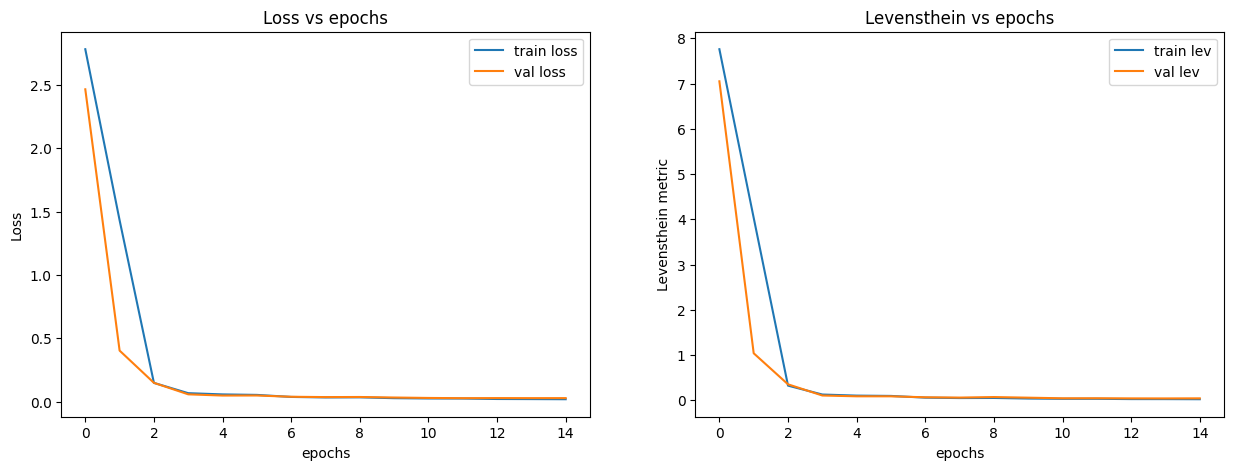

In [371]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(train_losses, label='train loss')
axes[0].plot(val_losses, label='val loss')
axes[0].set_title('Loss vs epochs')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(train_levs, label='train lev')
axes[1].plot(val_levs, label='val lev')
axes[1].set_title('Levensthein vs epochs')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Levensthein metric')
axes[1].legend()

plt.show()

In [372]:
class RecognitionDatasetTest(Dataset):
    def __init__(self, config, alphabet=abc, transforms=None):
        super(RecognitionDatasetTest, self).__init__()
        self.config                  = config
        self.image_names, self.texts = self._parse_root_()
        self.transforms              = transforms

    def _parse_root_(self):
        img_names, texts = [], []
        for img in self.config:
            img_names.append(img['file'])
            texts.append(img['text'])
        return img_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        pil_image   = Image.open(self.image_names[item])
        if pil_image.mode != "RGB":
            pil_image = pil_image.convert("RGB")

        torch_image = self.transforms(pil_image)
        
        text    = self.texts[item]
        output  = dict(torch_image=torch_image, pil_image=pil_image, text=text)
        
        return output

def collate_fn_test(batch):
    torch_images, pil_images, seqs, seq_lens, texts = [], [], [], [], []
  
    for item in batch:
        torch_images.append(item["torch_image"]  )
        pil_images  .append(item["pil_image"  ]  )
        texts       .append(item["text"       ]  )
    torch_images = torch.stack(torch_images)
    pil_images   = pil_images
   
    return {"torch_images": torch_images, "pil_images":pil_images, "text": texts}

In [373]:
test_dirs = os.listdir('test')
config = []
for dir in test_dirs:
    subdir = os.path.join('test', dir)
    for img_name in os.listdir(subdir):
        cur_data = {}
        cur_data['file'] = os.path.join(subdir, img_name)
        cur_data['text'] = img_name[:-4].split('_')[-1]
        config.append(cur_data)

test_dataset   = RecognitionDatasetTest(config, transforms=transforms)
test_dataloader   = DataLoader(test_dataset  , batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False, collate_fn=collate_fn_test)

In [384]:
checkpoint = torch.load("/kaggle/working/model_crnn.pt", weights_only=True)
crnn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [385]:
texts = []
ids = []
crnn.eval()
with torch.no_grad():
    for b in test_dataloader:
        preds = crnn(b['torch_images'].to(device)).cpu()
        texts_pred = decode(preds.detach(), abc)
        texts.extend(texts_pred)
        ids.extend(b['text'])

In [386]:
submission = pd.DataFrame({'index':ids, 'label':texts})
submission.sort_values(by='index', inplace=True)

In [387]:
submission.to_csv('submission.csv', index=False)